# How to Use NLTK to analyze a Text

In [2]:
import nltk
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob

# Download the NLTK sentiment analysis package
nltk.download('vader_lexicon')

# Create an instance of the SentimentIntensityAnalyzer class
analyzer = SentimentIntensityAnalyzer()

# Input text for sentiment analysis
text = """I cannot express enough how much I hated this movie. 
The story was so poorly written that I couldn't follow it, and the acting was even worse.
It was painful to watch these actors stumble through their lines, and I found myself wishing for the movie to end.
The special effects were also terrible, and I couldn't believe how cheap they looked.
Save yourself the time and money and skip this movie altogether."""

# Analyze sentiment using the SentimentIntensityAnalyzer
Polarity = analyzer.polarity_scores(text)

blob = TextBlob(text)

subjectivity = blob.sentiment.subjectivity

# Extract the sentiment scores
compound_score = Polarity['compound']
positive_score = Polarity['pos']
negative_score = Polarity['neg']
neutral_score = Polarity['neu']

# Print the sentiment scores
print("Compound Score: ", compound_score)
print("Positive Score: ", positive_score)
print("Negative Score: ", negative_score)
print("Neutral Score: ", neutral_score)

# Determine the overall sentiment label
if compound_score >= 0.05:
    sentiment_label = "Positive"
elif compound_score <= -0.05:
    sentiment_label = "Negative"
else:
    sentiment_label = "Neutral"
    
if subjectivity > 0.5:
    subjective_label = 'Subjective Comment'
else:
    subjective_label = 'Objective Comment'

# Print the overall sentiment label
print("Sentiment Label: ", sentiment_label)
print("Subjective Label: ",subjective_label)

Compound Score:  -0.7579
Positive Score:  0.095
Negative Score:  0.162
Neutral Score:  0.743
Sentiment Label:  Negative
Subjective Label:  Subjective Comment


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Web Scraping The Review Data

In [3]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service as ChromeService
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from scrapy import Selector
import time
import pandas as pd
import numpy as np
from tqdm import tqdm

# Specify the path to the Chrome driver executable
chrome_driver_path = 'chromedriver.exe'

# Create a Chrome service
chrome_service = ChromeService(executable_path=chrome_driver_path)

# Create a WebDriver instance
driver = webdriver.Chrome(service=chrome_service)

# Specify the URL to scrape
url = 'https://www.imdb.com/title/tt10168312/reviews?ref_=tt_urv'

# Load the URL in the WebDriver
driver.get(url)

# Wait for the reviews section to load
reviews_section = WebDriverWait(driver, 10).until(
    EC.presence_of_element_located((By.ID, 'content-2-wide'))
)

# Scroll down to the bottom of the page to load more reviews
while True:
    try:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        load_more_button = driver.find_element(By.CSS_SELECTOR, 'button.ipl-load-more__button')
        if not load_more_button.is_displayed():
            break
        load_more_button.click()
        # Wait for the new reviews to load
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'div.review-container'))
        )
    except:
        break

# Extract reviews from the loaded page
reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')
review_list = []

# Loop through the reviews and extract the review text
for d in tqdm(reviews):
    try:
        sel2 = Selector(text=d.get_attribute('innerHTML'))
        try:
            review = sel2.css('.text.show-more__control::text').extract_first()
        except:
            review = np.NaN
        review_list.append(review)
    except Exception as e:
        error_msg_list.append(e)

# Continue scrolling and loading more reviews until desired count is reached
while len(reviews) < 500:
    try:
        driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
        time.sleep(1)
        load_more_button = driver.find_element(By.CSS_SELECTOR, 'button.ipl-load-more__button')
        if not load_more_button.is_displayed():
            break
        load_more_button.click()
        # Wait for the new reviews to load
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CSS_SELECTOR, 'div.review-container'))
        )
    except:
        break

    # Extract reviews from the newly loaded page
    reviews = driver.find_elements(By.CSS_SELECTOR, 'div.review-container')
    for d in tqdm(reviews):
        try:
            sel2 = Selector(text=d.get_attribute('innerHTML'))
            try:
                review = sel2.css('.text.show-more__control::text').extract_first()
            except:
                review = np.NaN
            review_list.append(review)
        except Exception as e:
            error_msg_list.append(e)

# Create a DataFrame to store the extracted reviews
review_df = pd.DataFrame({'Review': review_list})

# Close the WebDriver
driver.close()

review_df.drop_duplicates(inplace=True)
review_df.reset_index(inplace=True,drop=True)

100%|████████████████████████████████████████████████████████████████████████████████| 425/425 [00:06<00:00, 61.46it/s]


In [4]:
review_df

,Review
0,"Now that the first season is over, I can confi..."
1,This is fun. I am enjoying every story.
2,A brilliant concept and a great way to view so...
3,Really enjoying this series & the risks they'v...
4,"Six episodes in, I have yet to be entertained ..."
...,...
419,"My son (12 years old, has seen every MCU movie..."
420,"Twightlight zone meets MCU, it's great if you ..."
421,Some of the premises in the show are cool and ...
422,"It's called what If for a reason,the stories w..."


In [5]:
def cleanReview(text):
    text = re.sub('@[A-Za-z0-9_]+', '', text)
    text = re.sub('#','',text)
    text = re.sub('RT[\s]+','',text)
    text = re.sub('https?:\/\/\S+', '', text) 
    text = re.sub('\n',' ',text)
    return text

In [6]:
review_df['CleanedReview'] = review_df['Review'].apply(cleanReview)
review_df.head()

,Review,CleanedReview
0,"Now that the first season is over, I can confi...","Now that the first season is over, I can confi..."
1,This is fun. I am enjoying every story.,This is fun. I am enjoying every story.
2,A brilliant concept and a great way to view so...,A brilliant concept and a great way to view so...
3,Really enjoying this series & the risks they'v...,Really enjoying this series & the risks they'v...
4,"Six episodes in, I have yet to be entertained ...","Six episodes in, I have yet to be entertained ..."


In [7]:
def analyze_sentiment(df, text_column):
    """
    Analyzes sentiment of text in a DataFrame column using VADER Sentiment Analyzer.

    Args:
        df (pd.DataFrame): DataFrame containing reviews
        text_column (str): Column name containing review text

    Returns:
        pd.DataFrame: DataFrame with added sentiment scores and labels
    """
    # Create a sentiment analyzer instance
    analyzer = SentimentIntensityAnalyzer()

    # Initialize lists to store sentiment scores and labels
    compound_scores = []
    positive_scores = []
    negative_scores = []
    neutral_scores = []
    subjectivity_scores = []
    sentiment_labels = []

    # Loop through the rows in the DataFrame
    for index, row in df.iterrows():
        text = row[text_column]
        scores = analyzer.polarity_scores(text)
        compound_score = scores['compound']
        positive_score = scores['pos']
        negative_score = scores['neg']
        neutral_score = scores['neu']
        # assuming the DataFrame already has a 'subjectivity' column

        # Determine the overall sentiment label
        if compound_score >= 0.05:
            sentiment_label = "Positive"
        elif compound_score <= -0.05:
            sentiment_label = "Negative"
        else:
            sentiment_label = "Neutral"

        # Append sentiment scores, subjectivity score, and labels to the lists
        compound_scores.append(compound_score)
        positive_scores.append(positive_score)
        negative_scores.append(negative_score)
        neutral_scores.append(neutral_score)
        sentiment_labels.append(sentiment_label)

    # Add sentiment scores, subjectivity score, and labels as new columns to the DataFrame
    df['Compound Score'] = compound_scores
    df['Positive Score'] = positive_scores
    df['Negative Score'] = negative_scores
    df['Neutral Score'] = neutral_scores
    df['Sentiment Label'] = sentiment_labels

    return df

In [8]:
df = analyze_sentiment(review_df, 'Review')

In [9]:
df['Sentiment Label'].value_counts()

Positive    312
Negative     76
Neutral      36
Name: Sentiment Label, dtype: int64

In [10]:
from textblob import TextBlob

# Add a new column for the subjectivity score
df['Subjectivity Score'] = df['Review'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Add a new column for the subjectivity label
df['Subjectivity Label'] = df['Subjectivity Score'].apply(lambda x: 'Subjective' if x > 0.5 else 'Objective')

In [11]:
from nltk.tokenize import word_tokenize

df['Word Count'] = df['CleanedReview'].apply(lambda x: len(word_tokenize(x)))

In [13]:
df

,Review,CleanedReview,Compound Score,Positive Score,Negative Score,Neutral Score,Sentiment Label,Subjectivity Score,Subjectivity Label,Word Count
0,"Now that the first season is over, I can confi...","Now that the first season is over, I can confi...",0.5520,0.058,0.037,0.905,Positive,0.517708,Subjective,178
1,This is fun. I am enjoying every story.,This is fun. I am enjoying every story.,0.7717,0.573,0.000,0.427,Positive,0.400000,Objective,10
2,A brilliant concept and a great way to view so...,A brilliant concept and a great way to view so...,-0.8679,0.214,0.256,0.530,Negative,0.651754,Subjective,107
3,Really enjoying this series & the risks they'v...,Really enjoying this series & the risks they'v...,0.3804,0.268,0.152,0.580,Positive,0.800000,Subjective,13
4,"Six episodes in, I have yet to be entertained ...","Six episodes in, I have yet to be entertained ...",-0.4147,0.133,0.170,0.698,Negative,0.863095,Subjective,75
...,...,...,...,...,...,...,...,...,...,...
419,"My son (12 years old, has seen every MCU movie...","My son (12 years old, has seen every MCU movie...",0.9804,0.158,0.030,0.813,Positive,0.570333,Subjective,252
420,"Twightlight zone meets MCU, it's great if you ...","Twightlight zone meets MCU, it's great if you ...",0.8834,0.407,0.000,0.593,Positive,0.700000,Subjective,24
421,Some of the premises in the show are cool and ...,Some of the premises in the show are cool and ...,0.8248,0.237,0.100,0.664,Positive,0.541667,Subjective,52
422,"It's called what If for a reason,the stories w...","It's called what If for a reason,the stories w...",0.4259,0.244,0.165,0.591,Positive,0.750000,Subjective,78


In [12]:
df['Subjectivity Label'].value_counts()

Subjective    255
Objective     169
Name: Subjectivity Label, dtype: int64

In [14]:
df['Sentiment Label'].value_counts()

Positive    312
Negative     76
Neutral      36
Name: Sentiment Label, dtype: int64

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

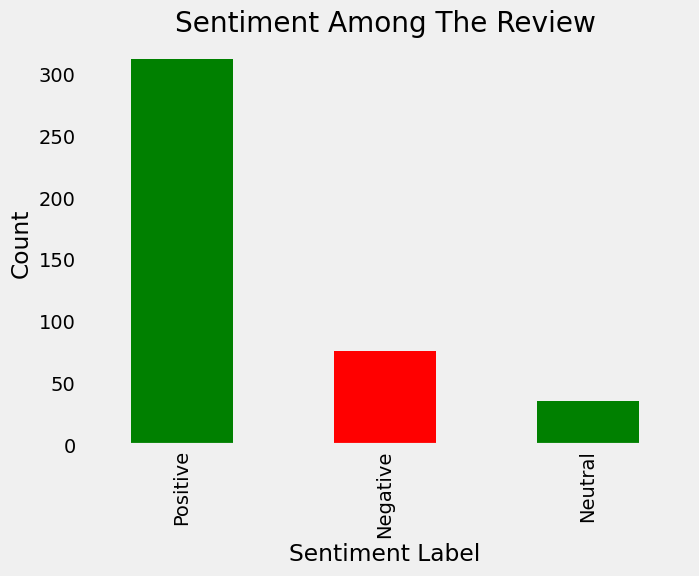

In [16]:
fig = plt.figure(figsize=(7,5))
color = ['green','red']
df['Sentiment Label'].value_counts().plot(kind='bar',color = color)
plt.title('Sentiment Among The Review')
plt.ylabel('Count')
plt.xlabel('Sentiment Label')
plt.grid(False)
plt.show()

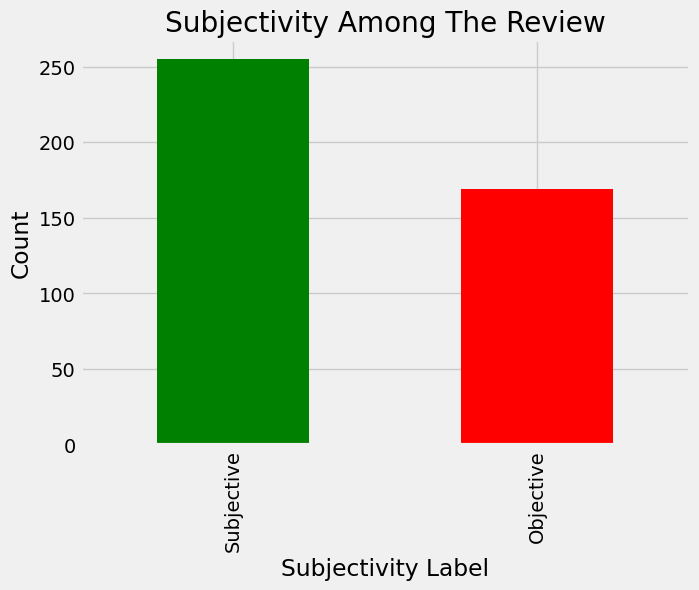

In [19]:
fig = plt.figure(figsize=(7,5))
color = ['green','red']
df['Subjectivity Label'].value_counts().plot(kind='bar',color = color)
plt.title('Subjectivity Among The Review')
plt.ylabel('Count')
plt.xlabel('Subjectivity Label')
plt.show()

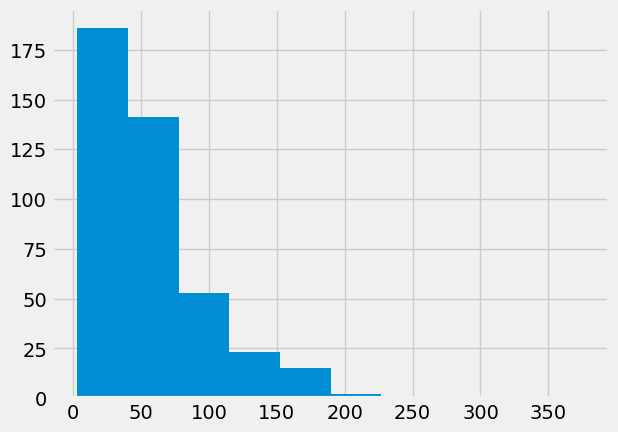

In [22]:
plt.hist(df['Word Count']);